# Variational Quantum Eigensolver (VQE)
In this section, the variational quantum eigensolver (VQE) is run on the simulator using Qulacs to find the ground state of the quantum chemical Hamiltonian obtained using OpenFermion/PySCF.

This notebook is translated from https://dojo.qulacs.org/ja/latest/notebooks/6.2_qulacs_VQE.html

Necessary packages:

* qulacs
* openfermion
* openfermion-pyscf
* pyscf
* scipy
* numpy

## Install and import necessary packages

In [2]:
## Please execute if various libraries are not installed
## When use Google Colaboratory, please ignore 'You must restart the runtime in order to use newly installed versions'.
## Crash when restarting runtime.
!pip install qulacs pyscf openfermion openfermionpyscf

In [4]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt

## Create Hamiltonian
Create Hamiltonian by PySCF in the same procedure as described in the previous section.

In [4]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

## Convert Hamiltonian to qulacs Hamiltonian
In Qulacs, observables like Hamiltonians are handled by the `Observable` class. There is a function `create_observable_from_openfermion_text` that converts OpenFermion Hamiltonian to Qulacs `Observable`.

In [5]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

## Construct ansatz
Construct a quantum circuit on Qulacs. Here, the quantum circuit is modeled after the experiments with superconducting qubits (A. Kandala et. al. , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246).

In [6]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [7]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

## Define VQE cost function
As explained in Section 5-1, VQE obtains an approximate ground state by minimizing the expected value 

\begin{equation}
\left<H(\theta)\right>=\left<\psi(\theta)|H|\psi(\theta)\right>
\end{equation}

of Hamiltonian for state $\left|\psi(\theta)\right>=U(\theta)\left|0\right>$ output from the quantum circuit $U(\theta)$ with parameters. The following defines a function that returns the expectation value of this Hamiltonian.


In [12]:
def cost(theta_list):
    state = QuantumState(n_qubit) #Prepare |00000>
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #Construct quantum circuit
    circuit.update_quantum_state(state) #Operate quantum circuit on state
    return qulacs_hamiltonian.get_expectation_value(state) #Calculate expectation value of Hamiltonian

## Run VQE
Now everthing is prepared, run VQE. For optimization, the BFGS method implemented in scipy is applied, and initial parameters are randomly selected. This process should end in tens of seconds.

In [9]:
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

The results can be plotted to see that they converge to the correct solution.

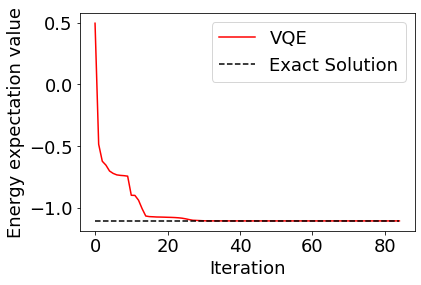

In [10]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

If you are interested, you can calculate the ground state by varying the `distance` between hydrogen atoms to find the interatomic distance at which the hydrogen molecule is most stable. (It should be about 0.74 angstroms, depending on the performance of the ansatz.)